In [17]:
import os
import joblib as jb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from typing import Optional, List, Dict, Union
import plotly
import plotly.graph_objs as go
from scipy.integrate import cumtrapz # intergrate trapezoidal rule
from scipy.signal import savgol_filter

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# graph styling
#plotly.offline.init_notebook_mode() # configure to render on the notebook
%matplotlib inline 
plt.style.use('seaborn-dark')
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

## Measured velocity & filenames lookup table

In [2]:
speeds_df = pd.read_csv('Speed-Filenames.csv')
speeds_df = speeds_df#.sort_values(by=['Speed']).reset_index(drop=True)
nans = speeds_df.isna().sum()

# check for missing data
for i in range(len(nans.index)):
    print(f'Column: {nans.index[i]}, Missing values: {nans[i]}')
speeds_df.head()

Column: Speed, Missing values: 0
Column: Filename, Missing values: 0


,Speed,Filename
0,65,13-32-19
1,65,13-34-21
2,59,13-36-55
3,66,13-37-30
4,66,13-38-16


In [3]:
def create_hist(data: Union[pd.Series, List], title: Optional[str] = None, xlabel: Optional[str] = None):
    '''
    plots histograms
    inputs:
        data: an array of to plot 
        title: optional string, graph title
        xlabel: optional string, x label title
    '''

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(data)
    
    # add the labels & remove borders 
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(xlabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def create_line(x: Union[pd.Series, List], y: Union[pd.Series, List], title: Optional[str] = None, 
                xlabel: Optional[str] = None, ylabel: Optional[str] = None):
    '''
    plots histograms
    inputs:
        x: an array of to plot
        y: an array of to plot
        title: optional string, graph title
        xlabel: optional string, x label title
        ylabel: optional string, y label title
    '''

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, y)
    
    # add the labels & remove borders
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def create_scatter(x: Union[pd.Series, List], y: Union[pd.Series, List], title: Optional[str] = None, 
                xlabel: Optional[str] = None, ylabel: Optional[str] = None):
    '''
    plots histograms
    inputs:
        x: an array of to plot
        y: an array of to plot
        title: optional string, graph title
        xlabel: optional string, x label title
        ylabel: optional string, y label title
    '''
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x, y)
    
    # add the labels & remove borders
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

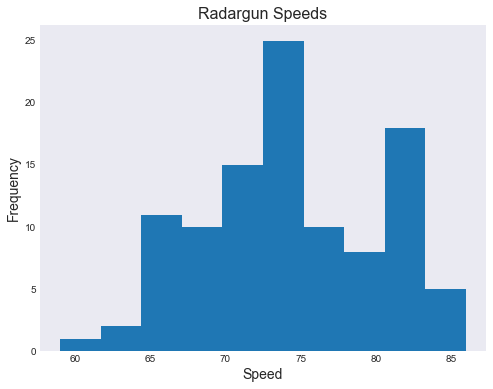

In [4]:
# distribution - radargun speeds
create_hist(speeds_df['Speed'], title='Radargun Speeds', xlabel='Speed')
plt.show()

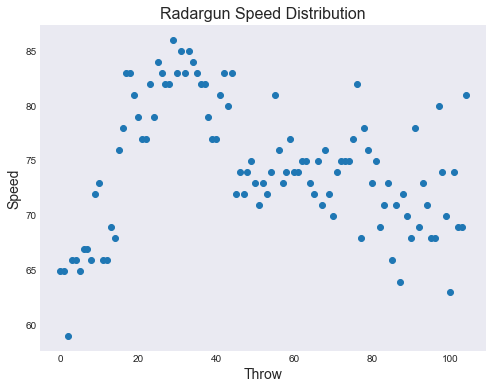

In [5]:
create_scatter(range(len(speeds_df)), speeds_df['Speed'], 
               title='Radargun Speed Distribution', 
               xlabel='Throw',
               ylabel='Speed')
plt.show()

**Note**:
* I'm assuming the velocity was measured at the end of the alloted time frame

## IMU Data

In [6]:
# load raw imu data
path = 'raw_imu_data/'
filenames = glob.glob(f'{path}*.txt')

In [7]:
# use the first file as a playground
df = pd.read_csv(filenames[0])
df.head()

,Time_s_,Acc_x_m_s_2_,Acc_y_m_s_2_,Acc_z_m_s_2_,Gyro_x_1_s_,Gyro_y_1_s_,Gyro_z_1_s_
0,0.000,0.156587,0.335328,0.051554,-0.429806,-0.978888,-0.494023
1,0.002,0.062543,0.420723,-0.018344,-0.409490,-0.947561,-0.487375
2,0.004,-0.033180,0.507209,-0.092663,-0.385810,-0.910554,-0.480350
3,0.006,-0.130096,0.596874,-0.174642,-0.358316,-0.867007,-0.473190
4,0.008,-0.228663,0.690690,-0.266529,-0.326435,-0.815904,-0.466010


In [12]:
# checking for missing values in the raw data
nan_count = 0
for file in filenames:
    df = pd.read_csv(file)
    
    nan_summary = df.isna().sum()    
    if nan_summary.sum() > 0:
        file = file.split('\\')[-1]
        nan_count += nan_summary.sum()
        with open ('nan_log.txt', 'a') as nan:
            nan.write(f'{file}:\n{nan_summary}\n')

if nan_count == 0:
    with open ('nan_log.txt', 'a') as nan:
        nan.write('No missing files in any of the raw data files')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Time_s_       1486 non-null   float64
 1   Acc_x_m_s_2_  1486 non-null   float64
 2   Acc_y_m_s_2_  1486 non-null   float64
 3   Acc_z_m_s_2_  1486 non-null   float64
 4   Gyro_x_1_s_   1486 non-null   float64
 5   Gyro_y_1_s_   1486 non-null   float64
 6   Gyro_z_1_s_   1486 non-null   float64
dtypes: float64(7)
memory usage: 81.4 KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_s_,1616.0,1.615000,0.933287,0.000000,0.807500,1.615000,2.422500,3.230000
Acc_x_m_s_2_,1616.0,12.740068,34.723636,-28.608881,-1.189517,4.282501,12.008454,195.632870
Acc_y_m_s_2_,1616.0,20.995922,31.116601,-13.688555,6.440263,10.393483,21.355540,188.935790
Acc_z_m_s_2_,1616.0,10.868256,28.967099,-54.346497,-1.762952,3.362943,13.324975,186.655650
Gyro_x_1_s_,1616.0,1.489933,5.512943,-28.203344,-0.541416,2.028122,4.616288,17.030846
Gyro_y_1_s_,1616.0,-0.810364,6.920763,-24.035248,-2.688447,-0.273813,1.621475,46.028690
Gyro_z_1_s_,1616.0,-0.716115,7.171059,-30.868517,-2.613961,-0.649205,1.244989,45.892357


**Few things to note**:
* Author converted the accelorometer data to meters by time sequared (m/s^2)
* Author converted the gyroscope data to rad (1/s)
* 0.002 seconds intervals 
* Assuming the device is calibrated

In [14]:
# should have done that sooner
df = df.rename(columns={
    "Time_s_": "time", 
    "Acc_x_m_s_2_": "acc_x",
    "Acc_y_m_s_2_": "acc_y",
    "Acc_z_m_s_2_": "acc_z",
    "Gyro_x_1_s_": "gyro_x",
    "Gyro_y_1_s_": "gyro_y",
    "Gyro_z_1_s_": "gyro_z",
})

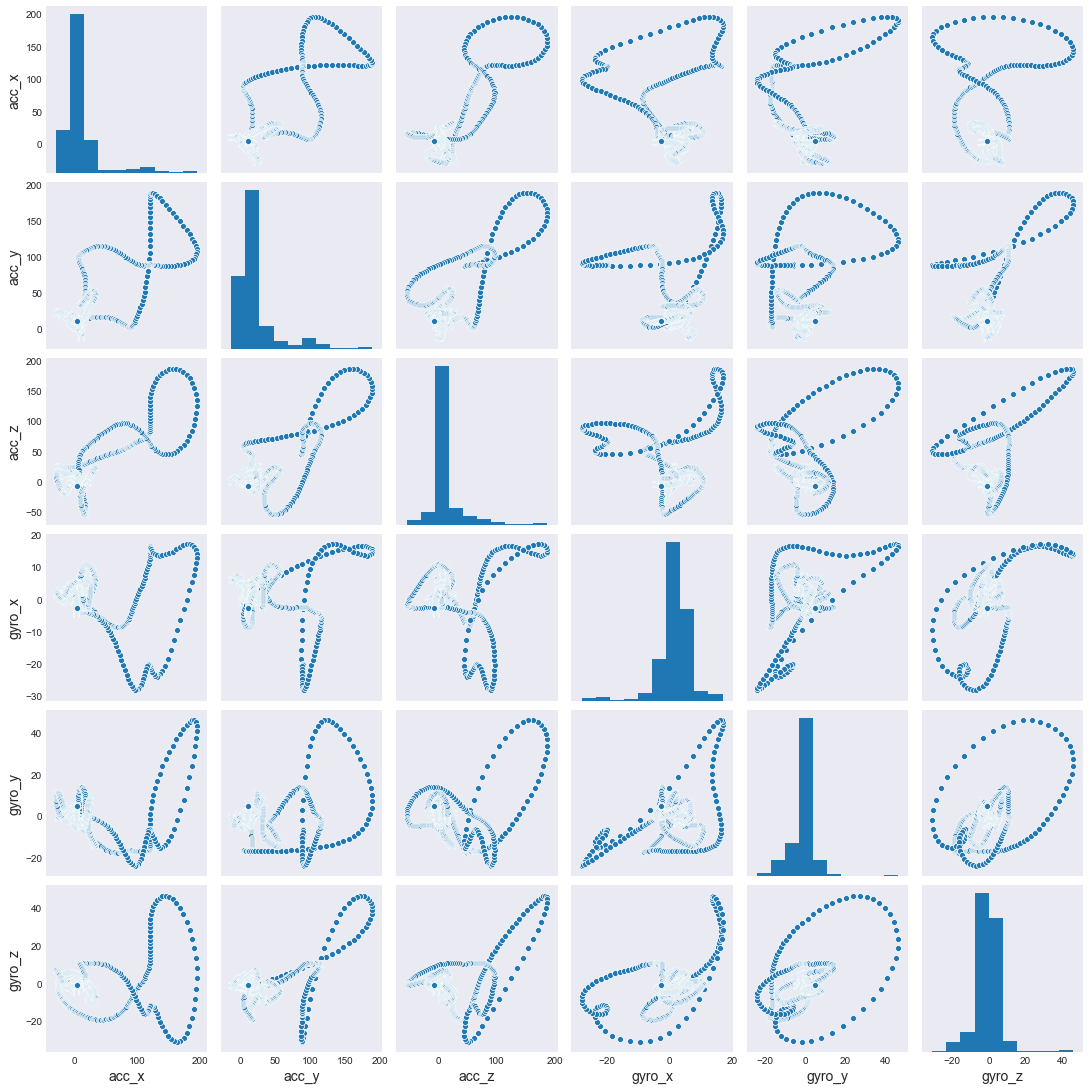

In [15]:
# distributions and pairwise relationship
columns = df.columns.tolist()
sns.pairplot(df[columns[1:]])
plt.show()

In [19]:
# the 2d relationships between the accelerations sparked my curiosity
z = df[columns[3]]
x = df[columns[1]]
y = df[columns[2]]

# configure the trace.
trace = go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.7,
        'color': x,
        'colorscale':'Viridis',
        'colorbar': dict(thickness=10)
    }
)

# configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# render the plot.
plotly.offline.iplot(plot_figure)
#plot_figure.write_image("figures/xyz_acceleration_graph.png")

In [ ]:
# lets look at change of acceleration over time in every axis
for axis in ['x', 'y', 'z']:
    xlabel = 'Time (s)'
    ylabel = 'Acceleration (m/s\u00b2)'
    title = f'Jerk - Change in Acceleration Over Time {axis.upper()} Axis'
    create_line(df['time'], df[f'acc_{axis}'], title=title, xlabel=xlabel, ylabel=ylabel)

**Note**:
* I hope the accelermoter is calibrated
* Although this is only the first throw I will assume peak acceleration would probably always be around happen between 0.5 to 1.5 seconds

## Calculate Velocity at Every Point Along the Trajectory

* The area between the axis and the acceleration function equals to the velocity 

In [ ]:

df['veloc_x'] = np.append(0.0, cumtrapz(df['acc_x'], x=df['time']))
df['veloc_y'] = np.append(0.0, cumtrapz(df['acc_y'], x=df['time']))
df['veloc_z'] = np.append(0.0, cumtrapz(df['acc_z'], x=df['time']))

for axis in ['x', 'y', 'z']:
    xlabel = 'Time (s)'
    ylabel = 'Velocity (m/s)'
    title = f'Change in Velocity Over Time Axis'
    create_line(df['time'], df[f'veloc_{axis}'], title=title, xlabel=xlabel, ylabel=ylabel)

In [ ]:
sns.pairplot(df[['veloc_x', 'veloc_y' ,'veloc_z']])
plt.show()

In [ ]:
df[['veloc_x', 'veloc_y' ,'veloc_z']].median(axis=0)

In [ ]:
df[['veloc_x', 'veloc_y' ,'veloc_z']].describe().T

## Filter Measurement Noise Tests

In [ ]:
processing_df = pd.DataFrame()
column_names = df.columns.tolist()
column_names.pop(0)

for column in column_names:
    new_data = moving_average(df[column].values, 151)
    processing_df[column] = new_data

# indetify the peak 
peak_idx = processing_df['acc_x'].idxmax()
peak_acc = processing_df.loc[peak_idx - 100:peak_idx + 100 , :]

In [ ]:
# goal: smoothen as minimally possible
processing_df
for axis in ['x', 'y', 'z']:
    xlabel = 'Time (s)'
    ylabel = 'Acceleration (m/s\u00b2)'
    title = f'Jerk - Change in Acceleration Over Time {axis.upper()} Axis'
    create_line(peak_acc.index, peak_acc[f'acc_{axis}'], title=title, xlabel=xlabel, ylabel='Rolling Average Time')
    create_hist(peak_acc[f'acc_{axis}'], title=f'{axis} Axis: Acceleration', xlabel='Acceleration')

## Trial and Error 

Before I start modeling I identified several actions I want to perform.

* Rename columns
* Focus on acceleration and ignore the angular velocity (for now)
* Smoothen the values to help reduce noise
* Calculate the acceleration vector magnitude
* Focusing on readings near the acceleration peak
* Scale the data
* Create a training and testing datasets
    * Each row would contain the acceleration magnitudes for a single throw (file)
    * Append the radar gun reading to the observations
    * Optional: Add wrist velocities